# 🎶 UK City Bands – Google Trends Analysis (2019–2024)
This notebook explores search interest in key UK bands by city of origin, using Google Trends data from the past 5 years. Each band's popularity is normalized using **The Beatles** as a reference anchor.

Cities included: London, Birmingham, Manchester, Glasgow, Liverpool, Leeds, Sheffield, Bradford, Bristol, Nottingham.

In [56]:
from pytrends.request import TrendReq
from pytrends.exceptions import ResponseError
import pandas as pd
import time
import random
import matplotlib.pyplot as plt
import os
from requests.exceptions import HTTPError

In [2]:
# 🔁 Extract band list from city dictionary
bands_by_city = {
    "London": ["The Rolling Stones", "The Clash", "Blur", "Coldplay", "Florence and the Machine"],
    "Birmingham": ["Black Sabbath", "ELO", "Duran Duran", "UB40", "Editors"],
    "Manchester": ["Oasis", "The Smiths", "New Order", "The Stone Roses", "The 1975"],
    "Glasgow": ["Simple Minds", "Primal Scream", "Belle and Sebastian", "Franz Ferdinand", "CHVRCHES"],
    "Liverpool": ["The Beatles", "Echo & the Bunnymen", "Frankie Goes to Hollywood", "The La's", "The Wombats"],
    "Leeds": ["Kaiser Chiefs", "Soft Cell", "Alt-J", "Sisters of Mercy", "The Wedding Present"],
    "Sheffield": ["Def Leppard", "The Human League", "Pulp", "Arctic Monkeys", "Bring Me The Horizon"],
    "Bradford": ["Smokie", "Tasmin Archer", "Kiki Dee", "Ivyrise", "The Cult"],
    "Bristol": ["Massive Attack", "Portishead", "Tricky", "Idles", "Kosheen"],
    "Nottingham": ["Jake Bugg", "Dog Is Dead", "London Grammar", "Ten Years After", "Sleaford Mods"]
}
all_bands = sorted(set(b for bands in bands_by_city.values() for b in bands))

In [ ]:
# fallback aliases to help suggestions (optional)
alias = {
    "ELO": "Electric Light Orchestra",
    "Alt-J": "alt-J",
    "CHVRCHES": "Chvrches",
    "Editors": "Editors band",
    "Pulp": "Pulp band",
    "Idles": "Idles band",
    "Smokie": "Smokie band",
}

# acceptable types in descending priority
ACCEPT_TYPES = [
    "Band", "Rock band", "Pop band", "Musical group", "Music group", "Indie rock band",
    "Singer", "Singer-songwriter", "Artist"
]

CACHE_CSV = "band_topics.csv"

# ---- Load cache if available ----
if os.path.exists(CACHE_CSV):
    print(f"📁 Using existing {CACHE_CSV}")
    df_topics = pd.read_csv(CACHE_CSV)
else:
    print("⚠️ Cache not found. Fetching from Google Trends...")
    df_topics = pd.DataFrame(columns=["band","mid","title","type"])

# ---- Check for missing bands ----
have = set(df_topics["band"])
missing = [b for b in all_bands if b not in have]

if missing:
    print(f"🔎 Fetching {len(missing)} missing bands from Google Trends…")
    pytrends = TrendReq(hl="en-US", tz=0, timeout=(10, 25))
    records = df_topics.to_dict("records")

    for band in missing:
        q = alias.get(band, band)
        try:
            sugg = pytrends.suggestions(q) or []
            # pick best by priority
            pick = None
            by_type = {s["type"]: s for s in sugg if "type" in s and "mid" in s}
            for t in ACCEPT_TYPES:
                if t in by_type:
                    pick = by_type[t]
                    break
            if pick is None:
                pick = next((s for s in sugg if "band" in s.get("type","").lower()), None)
            if pick is None and sugg:
                pick = sugg[0]
            if pick:
                records.append({
                    "band": band,
                    "mid": pick["mid"],
                    "title": pick.get("title", band),
                    "type": pick.get("type","")
                })
            else:
                print(f"⚠️ No topic for {band}")
        except Exception as e:
            print(f"❌ {band}: {e}")
        time.sleep(2.5)  # slow down to avoid blocks

    df_topics = pd.DataFrame(records).drop_duplicates(subset=["band"], keep="first").sort_values("band")
    df_topics.to_csv(CACHE_CSV, index=False)
    print(f"💾 Updated {CACHE_CSV}")
else:
    print("✅ All bands already cached")

df_topics.head()

❌ Black Sabbath: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
❌ Kosheen: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))
❌ Simple Minds: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))


,band,mid,title,type
0,Alt-J,/m/0k3lyz1,alt-J,Rock band
1,Arctic Monkeys,/m/05q_9w,Arctic Monkeys,Rock band
2,Belle and Sebastian,/m/01cng,Belle and Sebastian,Pop band
3,Blur,/m/0bt8c,Blur,Band
4,Bring Me The Horizon,/m/0l030d,Bring Me The Horizon,Rock band


In [39]:
pytrends = TrendReq(hl="en-US", tz=0)

pytrends.suggestions("Simple Minds")

[{'mid': '/g/11w_hjng6d', 'title': 'Simple Minds', 'type': 'Event'},
 {'mid': '/g/11lzx1lyxx', 'title': 'Simple Minds', 'type': 'Topic'},
 {'mid': '/g/11y8h4q4xh', 'title': 'Simple Minds', 'type': 'Event'},
 {'mid': '/m/016vj5', 'title': 'Simple Minds', 'type': 'Rock band'},
 {'mid': '/g/11wn5z8b17',
  'title': 'Simple Minds at Freilichtbuhne Loreley',
  'type': 'Event'}]

In [38]:
pytrends = TrendReq(hl="en-US", tz=0)
pytrends.build_payload(
    kw_list=["/m/01czx"],   # this is the topic ID for Taylor Swift
    cat=0,
    timeframe="today 5-y",
    geo="",
    gprop=""
)
df = pytrends.interest_over_time()
df.head()

/Users/dpradilla/dev/python_uk_bands/venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)


,/m/01czx,isPartial
date,,
2020-08-23,4,False
2020-08-30,4,False
2020-09-06,5,False
2020-09-13,5,False
2020-09-20,4,False


In [40]:

# load topics
df_topics = pd.read_csv("band_topics.csv")
band_to_mid = dict(zip(df_topics["band"], df_topics["mid"]))

# keyword fallback for ambiguous names
kw_fallback = {
    "Pulp": "Pulp band",
    "Editors": "Editors band",
    "Idles": "Idles band",
    "The Cult": "The Cult band",
    "Smokie": "Smokie band",
    "Alt-J": "alt-J band",
    "CHVRCHES": "CHVRCHES band",
    "Soft Cell": "Soft Cell band",
}

def kw_for(band): return kw_fallback.get(band, band)

anchor = "The Beatles"
anchor_mid = band_to_mid.get(anchor)

CACHE = "google_trends_band_interest.csv"
if os.path.exists(CACHE):
    print(f"📁 Using existing {CACHE}")
    normalized_df = pd.read_csv(CACHE, index_col=0)
else:
    pytrends = TrendReq(hl="en-US", tz=0)
    batch_size = 4
    frames = []

    for i in range(0, len(all_bands), batch_size):
        batch_bands = all_bands[i:i+batch_size]

        # ---- attempt 1: topics only ----
        mids = [band_to_mid[b] for b in batch_bands if b in band_to_mid]
        if anchor_mid and anchor_mid not in mids:
            mids = [anchor_mid] + mids
        mids = list(dict.fromkeys(mids))
        df = None

        if len(mids) >= 2:
            try:
                pytrends.build_payload(kw_list=mids, timeframe="today 5-y", geo="GB", gprop="")
                df = pytrends.interest_over_time()
                if df is not None and not df.empty:
                    if "isPartial" in df.columns: df = df.drop(columns=["isPartial"])
                    # rename columns from mid->band
                    mid_to_band = {band_to_mid[b]: b for b in batch_bands if b in band_to_mid}
                    if anchor_mid: mid_to_band[anchor_mid] = anchor
                    df = df.rename(columns=lambda c: mid_to_band.get(c, c))
            except Exception as e:
                df = None  # fall through to keywords

        # ---- attempt 2: keyword fallback ----
        if df is None or df.empty:
            terms = [kw_for(b) for b in batch_bands]
            if anchor not in terms: terms = [anchor] + terms
            terms = list(dict.fromkeys(terms))
            if len(terms) >= 2:
                try:
                    pytrends.build_payload(kw_list=terms, timeframe="today 5-y", geo="GB", gprop="")
                    df = pytrends.interest_over_time()
                    if df is not None and not df.empty and "isPartial" in df.columns:
                        df = df.drop(columns=["isPartial"])
                except Exception as e2:
                    print(f"❌ Skipping batch {batch_bands}: {e2}")
                    df = None

        if df is not None and not df.empty:
            frames.append(df)

        time.sleep(1.2)

    if not frames:
        raise RuntimeError("No data returned from Google Trends.")
    merged_df = pd.concat(frames, axis=1)
    merged_df = merged_df.loc[:, ~merged_df.columns.duplicated(keep="first")]

    # ensure anchor column exists
    if anchor not in merged_df.columns:
        raise RuntimeError("Anchor series 'The Beatles' not found in merged data (after rename/fallback).")

    # normalize so The Beatles peak = 100
    anchor_max = merged_df[anchor].max()
    if not pd.notna(anchor_max) or anchor_max <= 0:
        raise RuntimeError("Anchor has no positive values; cannot normalize.")
    normalized_df = merged_df.div(anchor_max).mul(100)
    normalized_df.to_csv(CACHE)
    print(f"💾 Saved {CACHE}")

normalized_df.head()

/Users/dpradilla/dev/python_uk_bands/venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/Users/dpradilla/dev/python_uk_bands/venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/Users/dpradilla/dev/python_uk_bands/venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result

💾 Saved google_trends_band_interest.csv


,The Beatles,Alt-J,Arctic Monkeys,Belle and Sebastian,Black Sabbath,Blur,Bring Me The Horizon,CHVRCHES,Coldplay,Def Leppard,...,The Cult,The Human League,The La's,The Rolling Stones,The Smiths,The Stone Roses,The Wedding Present,The Wombats,Tricky,UB40
date,,,,,,,,,,,,,,,,,,,,,
2020-08-23,15.384615,0.0,4.615385,0.0,1.538462,1.538462,1.538462,0.0,3.076923,1.538462,...,0.000000,1.538462,0.0,0.0,3.076923,3.076923,0.0,0.0,0.0,4.615385
2020-08-30,16.923077,0.0,4.615385,0.0,1.538462,1.538462,1.538462,0.0,3.076923,1.538462,...,0.000000,1.538462,0.0,0.0,3.076923,4.615385,0.0,0.0,0.0,3.076923
2020-09-06,15.384615,0.0,4.615385,0.0,1.538462,1.538462,1.538462,0.0,3.076923,1.538462,...,1.538462,1.538462,0.0,0.0,3.076923,3.076923,0.0,0.0,0.0,3.076923
2020-09-13,15.384615,0.0,3.076923,0.0,3.076923,1.538462,1.538462,0.0,3.076923,1.538462,...,0.000000,1.538462,0.0,0.0,3.076923,3.076923,0.0,0.0,0.0,3.076923
2020-09-20,15.384615,0.0,4.615385,0.0,1.538462,1.538462,1.538462,0.0,3.076923,1.538462,...,0.000000,3.076923,0.0,0.0,3.076923,3.076923,0.0,0.0,0.0,3.076923


In [41]:
# 🧬 Normalize and save
if os.path.exists("google_trends_band_interest.csv"):
    print("📁 Using cached google_trends_band_interest.csv")
    normalized_df = pd.read_csv("google_trends_band_interest.csv", index_col=0)
else:
    # 🔁 This block only runs if data needs to be fetched and normalized
    merged_df = pd.concat(batched_data, axis=1)
    merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
    anchor_max = merged_df[anchor].max()
    normalized_df = merged_df.div(anchor_max).multiply(100)
    normalized_df.to_csv("google_trends_band_interest.csv")


📁 Using cached google_trends_band_interest.csv


## 🌍 Global Interest Chart
In addition to UK-only interest, this chart shows **global average search interest** over the past 5 years.

In [57]:
# expects: all_bands, band_to_mid (from band_topics.csv), anchor="The Beatles"
# fallback disambiguation for keywords
kw_fallback = {
    "Pulp": "Pulp band", "Editors": "Editors band", "Idles": "Idles band",
    "The Cult": "The Cult band", "Smokie": "Smokie band",
    "Alt-J": "alt-J band", "CHVRCHES": "CHVRCHES band", "Soft Cell": "Soft Cell band",
}

def kw_for(b): return kw_fallback.get(b, b)

GLOBAL_CACHE = "google_trends_global_band_interest.csv"

if os.path.exists(GLOBAL_CACHE):
    print(f"📁 Using existing {GLOBAL_CACHE}")
    normalized_global = pd.read_csv(GLOBAL_CACHE, index_col=0)
else:
    pytrends = TrendReq(hl="en-US", tz=0, timeout=(10, 25))
    batch_size = 4
    frames = []
    anchor_mid = band_to_mid.get(anchor)

    for i in range(0, len(all_bands), batch_size):
        batch_bands = all_bands[i:i+batch_size]

        # ---- Try topics (mids) only ----
        mids = [band_to_mid[b] for b in batch_bands if b in band_to_mid]
        if anchor_mid and anchor_mid not in mids:
            mids = [anchor_mid] + mids
        mids = list(dict.fromkeys(mids))

        df = None
        if len(mids) >= 2:
            try:
                pytrends.build_payload(kw_list=mids, timeframe="today 5-y", geo="")
                df = pytrends.interest_over_time()
                if df is not None and not df.empty:
                    if "isPartial" in df.columns: df = df.drop(columns=["isPartial"])
                    # rename mid columns to band names
                    mid_to_band = {band_to_mid[b]: b for b in batch_bands if b in band_to_mid}
                    if anchor_mid: mid_to_band[anchor_mid] = anchor
                    df = df.rename(columns=lambda c: mid_to_band.get(c, c))
            except Exception:
                df = None

        # ---- Fallback: disambiguated keywords ----
        if df is None or df.empty:
            terms = [kw_for(b) for b in batch_bands]
            if anchor not in terms: terms = [anchor] + terms
            terms = list(dict.fromkeys(terms))
            if len(terms) >= 2:
                try:
                    pytrends.build_payload(kw_list=terms, timeframe="today 5-y", geo="")
                    df = pytrends.interest_over_time()
                    if df is not None and not df.empty and "isPartial" in df.columns:
                        df = df.drop(columns=["isPartial"])
                except Exception as e2:
                    print(f"❌ Skipping batch {batch_bands}: {e2}")
                    df = None

        if df is not None and not df.empty:
            frames.append(df)

        time.sleep(random.uniform(2.5, 5.0))  # be gentle globally

    if not frames:
        raise RuntimeError("No global data returned (topics + keyword fallbacks failed).")

    global_df = pd.concat(frames, axis=1)
    global_df = global_df.loc[:, ~global_df.columns.duplicated(keep="first")]

    if anchor not in global_df.columns:
        raise RuntimeError("Anchor 'The Beatles' not found in global data.")

    # ✅ Normalize with scalar Beatles peak = 100 (not per-row series division)
    beatles_peak = global_df[anchor].max()
    if not pd.notna(beatles_peak) or beatles_peak <= 0:
        raise RuntimeError("Beatles global series has no positive values; cannot normalize.")

    normalized_global = (global_df / beatles_peak) * 100
    normalized_global.to_csv(GLOBAL_CACHE)
    print(f"💾 Saved {GLOBAL_CACHE}")

/Users/dpradilla/dev/python_uk_bands/venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/Users/dpradilla/dev/python_uk_bands/venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(False)
/Users/dpradilla/dev/python_uk_bands/venv/lib/python3.13/site-packages/pytrends/request.py:260: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result

💾 Saved google_trends_global_band_interest.csv


### 📊 Interpreting Normalized Google Trends Data

Google Trends doesn’t give absolute search counts. Instead, it reports **relative search interest** on a scale from **0 to 100**:

- **100 = the peak popularity** of a term in the selected time and region.  
- All other values are relative to that peak (e.g. 50 = half as many searches as at the peak).  

In our analysis we used **The Beatles** as an anchor. Their highest point of search activity in the last 5 years is set to **100**, and every other band is scaled relative to that moment.  

What this means:  
- The Beatles at their *biggest spike* = 100.  
- The Beatles on most weeks are much lower (often 20–40).  
- When we take the **average across 5 years**, The Beatles land around 30.  

So why might **Pulp** or **Coldplay** appear above The Beatles in the charts?  
- The Beatles’ search pattern is **spiky**: a huge surge around events (e.g. the *Get Back* documentary) but relatively quiet otherwise.  
- Pulp’s searches are **flatter and more consistent**, so their *average* relative interest can look higher, even though their absolute peak never beats The Beatles.  

👉 Key takeaway:  
- **Peak interest** shows which band captured the largest single moment of attention.  
- **Average interest** shows which bands sustain steady curiosity over time.  

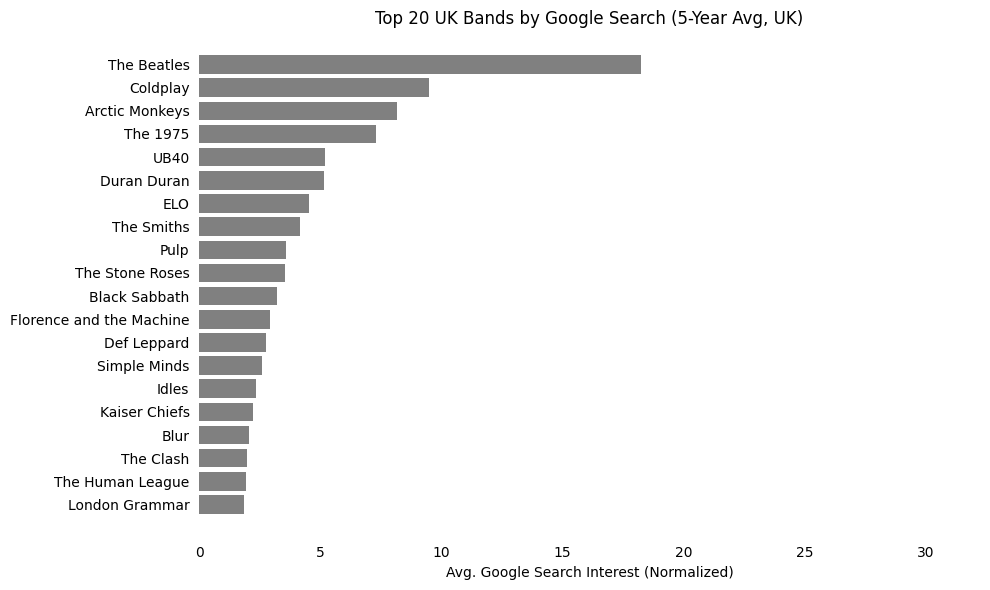

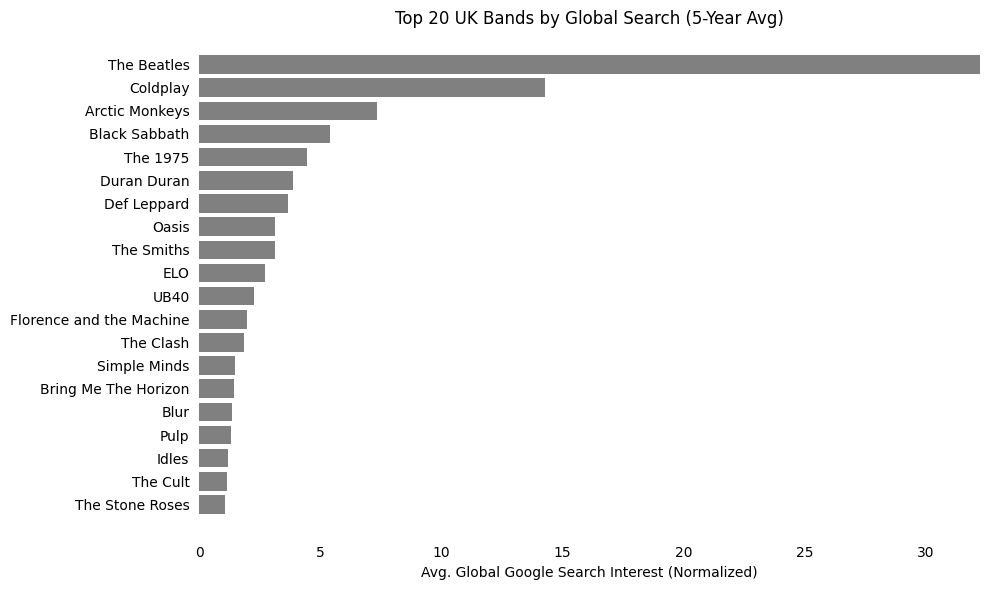

In [66]:
# get shared max
shared_max = max(top_20.max(), top_20_global.max())

# 📊 Top 20 UK
plt.figure(figsize=(10, 6))
plt.barh(top_20.index[::-1], top_20.values[::-1], color="gray", edgecolor="none")
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
plt.xlabel("Avg. Google Search Interest (Normalized)")
plt.title("Top 20 UK Bands by Google Search (5-Year Avg, UK)")
plt.xlim(0, shared_max)   # 🔑 same scale
plt.tight_layout()
plt.show()

# 📊 Top 20 Global
plt.figure(figsize=(10, 6))
plt.barh(top_20_global.index[::-1], top_20_global.values[::-1], color="gray", edgecolor="none")
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
plt.xlabel("Avg. Global Google Search Interest (Normalized)")
plt.title("Top 20 UK Bands by Global Search (5-Year Avg)")
plt.xlim(0, shared_max)   # 🔑 same scale
plt.tight_layout()
plt.show()

## 🏙️ Cultural Impact by City (Google Search Interest)
We've been looking at bands individually, but the original question was: **which UK cities have the biggest cultural impact through music?**

To answer that, we now aggregate normalized search interest by city, using the band–city mapping. This gives us a total cultural 'footprint' based on the popularity of each city's artists across the UK.

In [59]:
# Aggregate city-level cultural impact
band_city_lookup = {band: city for city, bands in bands_by_city.items() for band in bands}
band_averages = normalized_df.mean()
city_scores = {}
for band, score in band_averages.items():
    city = band_city_lookup.get(band)
    if city:
        city_scores[city] = city_scores.get(city, 0) + score

# Convert to DataFrame
city_df = pd.DataFrame.from_dict(city_scores, orient='index', columns=['TotalSearchImpact'])
city_df = city_df.sort_values('TotalSearchImpact', ascending=True)

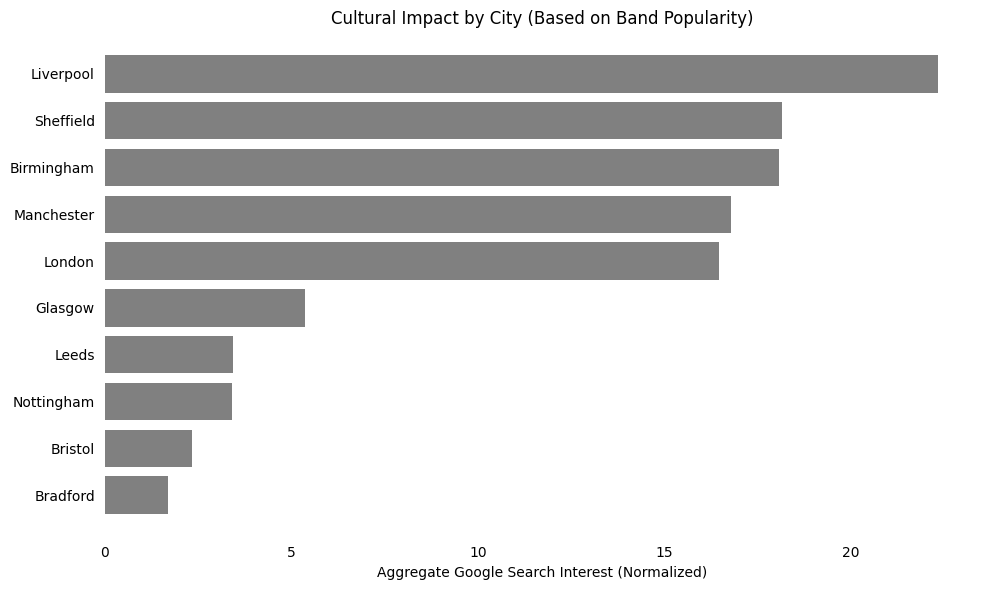

In [60]:
# Plot city impact
plt.figure(figsize=(10, 6))
plt.barh(city_df.index, city_df['TotalSearchImpact'], color="gray", edgecolor="none")
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
plt.xlabel("Aggregate Google Search Interest (Normalized)")
plt.title("Cultural Impact by City (Based on Band Popularity)")
plt.tight_layout()
plt.show()

## 🧠 Better Metrics for City Cultural Impact
Because our search interest scores are normalized (not absolute), simple aggregation can misrepresent cultural impact.

Instead, we use two smarter metrics:
1. **Average Search Interest per City** – how strong a city's artists are on average
2. **Top Band per City** – the single most searched band for each city

In [61]:
# 🎯 Metric 1: Average search interest per city
city_scores_avg = {}
for band, score in band_averages.items():
    city = band_city_lookup.get(band)
    if city:
        city_scores_avg.setdefault(city, []).append(score)

city_avg_df = pd.DataFrame({
    city: sum(scores) / len(scores)
    for city, scores in city_scores_avg.items()
}, index=["AvgSearchImpact"]).T.sort_values("AvgSearchImpact", ascending=True)

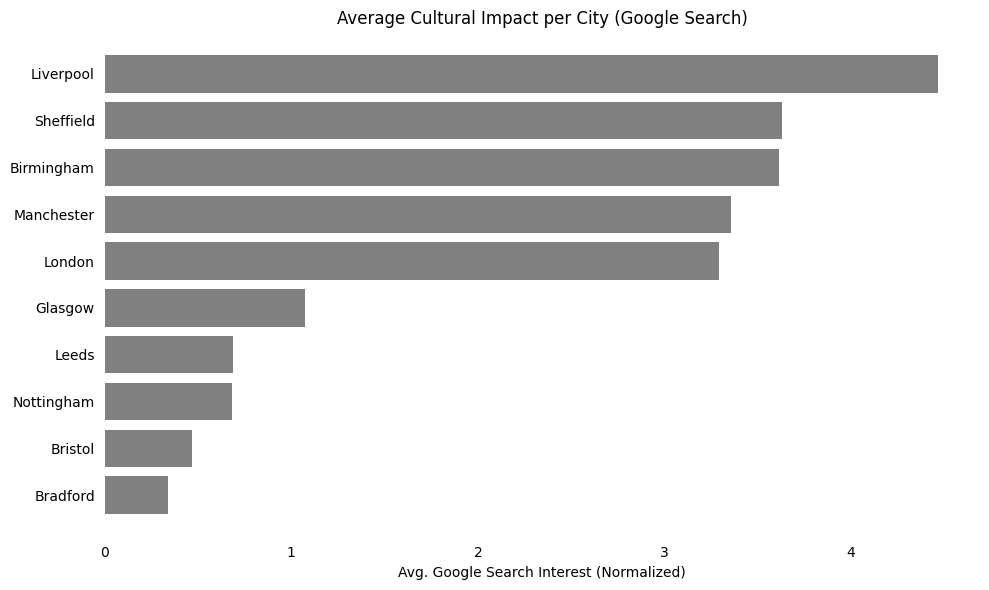

In [62]:
# 📊 Plot average per city
plt.figure(figsize=(10, 6))
plt.barh(city_avg_df.index, city_avg_df['AvgSearchImpact'], color="gray", edgecolor="none")
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
plt.xlabel("Avg. Google Search Interest (Normalized)")
plt.title("Average Cultural Impact per City (Google Search)")
plt.tight_layout()
plt.show()

In [63]:
# 🎖️ Metric 2: Top band per city
top_band_per_city = {}
for band, city in band_city_lookup.items():
    score = band_averages.get(band)
    if score is not None:
        current_top = top_band_per_city.get(city, (None, -1))
        if score > current_top[1]:
            top_band_per_city[city] = (band, score)

top_band_df = pd.DataFrame(
    [(city, band, score) for city, (band, score) in top_band_per_city.items()],
    columns=["City", "Band", "SearchImpact"]
).sort_values("SearchImpact", ascending=True)

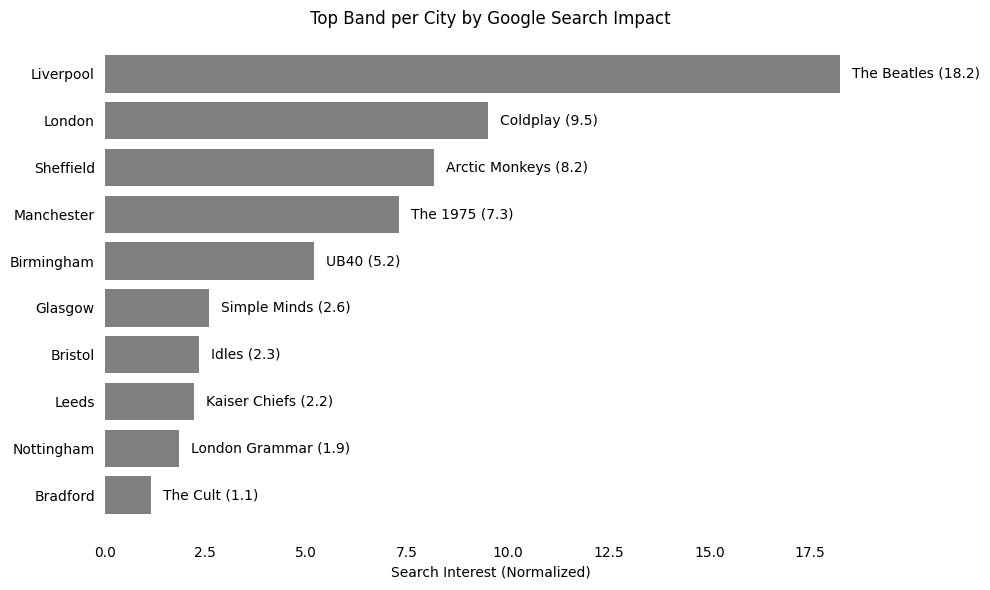

In [64]:
# 📊 Plot top band per city
plt.figure(figsize=(10, 6))
bars = plt.barh(top_band_df['City'], top_band_df['SearchImpact'], color="gray", edgecolor="none")
for bar, band in zip(bars, top_band_df['Band']):
    width = bar.get_width()
    plt.text(width + 0.3, bar.get_y() + bar.get_height()/2, f"{band} ({width:.1f})", va='center')
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
plt.xlabel("Search Interest (Normalized)")
plt.title("Top Band per City by Google Search Impact")
plt.tight_layout()
plt.show()

## 📈 City Cultural Impact vs Population
Does city size correlate with cultural influence through music?

We compare each city's **average search interest** (from earlier) with its **population** using a scatterplot.

> 🔍 Note: Normalized search interest means each band's scores are scaled relative to The Beatles' max UK interest. Still, since we're averaging across time, **bands with consistent long-term interest** may end up ranked higher than bands with one very high but brief spike — like The Beatles.

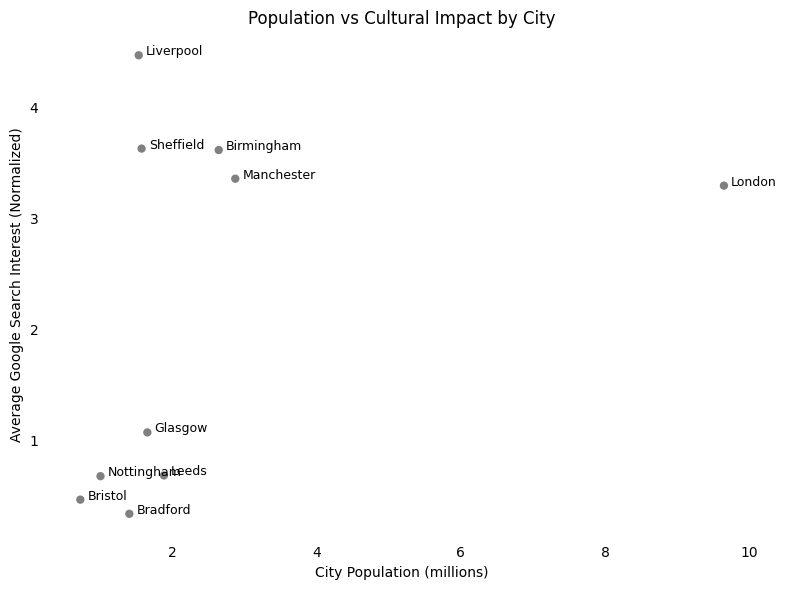

In [65]:
# 📊 Scatterplot: Population vs Cultural Impact
city_pop = {
    "London": 9.65,
    "Birmingham": 2.64,
    "Manchester": 2.87,
    "Glasgow": 1.65,
    "Liverpool": 1.53,
    "Leeds": 1.88,
    "Sheffield": 1.57,
    "Bradford": 1.40,
    "Bristol": 0.72,
    "Nottingham": 1.00
}

# Join population and cultural impact
pop_series = pd.Series(city_pop)
scatter_df = city_avg_df.join(pop_series.rename("Population"), how="inner")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(scatter_df["Population"], scatter_df["AvgSearchImpact"], color="gray", edgecolors="none")

# Add city labels
for city, row in scatter_df.iterrows():
    plt.text(row["Population"] + 0.1, row["AvgSearchImpact"], city, fontsize=9)

# Style
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(left=False, bottom=False)
plt.xlabel("City Population (millions)")
plt.ylabel("Average Google Search Interest (Normalized)")
plt.title("Population vs Cultural Impact by City")
plt.tight_layout()
plt.show()